In [1]:
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Theoretical task

Target variable $y\sim Laplace(\alpha, \beta)$, $p(y = z) = \frac{1}{2\beta}exp(-\frac{|{z-\alpha}|}{\beta})$, with $\mathrm{E}[y] = \alpha$ and $\mathrm{Var}[y] = 2\beta^2$.  
Let $x_{(m\times n)}$ - our data, $\theta_{(n\times1)}$ - vector of parameters.  
Then $y$ may be represented as $f(x) = x\theta + \xi$,  
where $\xi\sim N(0, \sigma^2)$, and $\mathrm{E}[f(x)] = x\theta$, $\mathrm{Var}[f(x)] = \sigma^2$.
Hence, $\alpha = x\theta$ and $2\beta^2 = \sigma^2$  

So if we want to maximize likelihood, then:  

$p(t|x, \theta, \sigma^2) = \prod \limits_{i=1}^m\frac{1}{2\beta}exp(-\frac{|{t_i-\alpha}|}{\beta}) = \prod \limits_{i=1}^m\frac{1}{\sigma\sqrt{2}}exp(-\frac{\sqrt{2}|{t_i-x_i\theta}|}{\sigma})$  
$\ln{p(t|x, \theta, \sigma^2)} = -\sum \limits_{i=1}^m\frac{\sqrt{2}|{t_i-x_i\theta}|}{\sigma} + m\ln{\frac{1}{\sigma\sqrt{2}}}$  
Assuming that $\sigma$ doesn't depend on target values, optimal $\theta = argmin \sum \limits_{i=1}^m|{t_i-x_i\theta}|$.  

So if our target values have Laplace distribution, then we need to use _MAE_ as our _loss function_.

### Bayesian approach
In the case of _Bayesian approach_ we will maximize _posterior probability_ $p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)}$.  
Hence, in this case we take into account distribution of our parameters $\theta$.  


$\ln{p(\theta|t)} = -\sum \limits_{i=1}^m\frac{\sqrt{2}|{t_i-x_i\theta}|}{\sigma} + m\ln{\frac{1}{\sigma\sqrt{2}}} + \ln{p(\theta)}$

$\theta\sim Laplace(\mu = 0, \frac{\Sigma}{\lambda})$, where $\mu$ is a vector of mean values of $\theta$ and  
$\Sigma$ - identity matrix of covariance.

$p(\theta_{n\times1}) = \displaystyle f_{\mathbf {\theta} }(\theta_{1},\ldots ,\theta_{n})={\frac {2\sqrt{\lambda}}{(2\pi )^{n/2}|{\boldsymbol {\Sigma }}|^{0.5}}}\left({\frac {\lambda\mathbf {\theta}^{T}{\boldsymbol {\Sigma }}^{-1}\mathbf {\theta} }{2}}\right)^{v/2}K_{v}\left({\sqrt {2\mathbf {\theta}^T{\lambda\boldsymbol {\Sigma }}^{-1}\mathbf {\theta} }}\right)$  
$\displaystyle v=(2-n)/2$.  
$\displaystyle K_v$ is the modified Bessel function of the second kind.

$\ln{p(\theta)} = \ln{\frac{2}{(2\pi)^k/2}} + \frac{\displaystyle v}{2}\ln{(\lambda\frac{\theta^T\theta}{2})} + \ln{K_{v}\left({\sqrt {2\mathbf {\theta}^T{\lambda}\mathbf {\theta} }}\right)}$  

Hence $\theta = argmin \sum \limits_{i=1}^m|{t_i-x_i\theta}| + \ln{(\lambda\frac{\theta^T\theta}{2})} + \ln{K_{v}\left({\sqrt {2\mathbf {\theta}^T{\lambda}\mathbf {\theta} }}\right)}$
Вот что делать с $K_v$ я не знаю

# ------------------------------------------------MODEL----------------------------------------------------
We will build _3-layer perceptron_ which will be trained, using _MNIST digits dataset_, to distinguish handwritten digits.  

We'll follow the next steps:  

1. Loading data  


2. Feature analysis and engineering  


3. Building the model:
    * Define activation functions and hidden layers sizes
    * Define the _loss function_
    * Define _learning algorithm_  
    * Implement through the code


4. Train the model  


5. Evaluate perfomance and optimize it  


6. Make prediction

# Loading the data

In [2]:
mnist = np.load('./mnist.npz')
x_train = mnist['x_train']
y_train = mnist['y_train']
x_test = mnist['x_test']
y_test = mnist['y_test']
print('Train shape: {}, Test shape: {}'.format(x_train.shape, x_test.shape))

Train shape: (60000, 28, 28), Test shape: (10000, 28, 28)


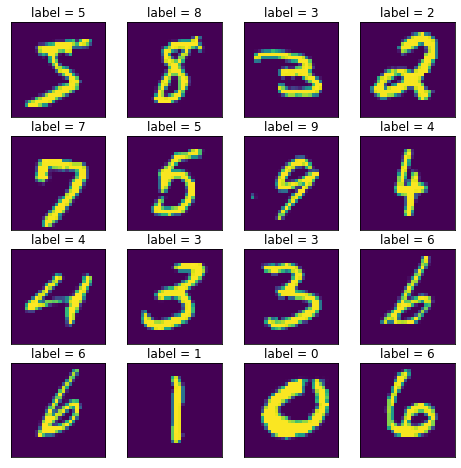

In [3]:
fig, ax = plt.subplots(4, 4, figsize = (8, 8))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(x_train[371*i + 125*j])
        ax[i, j].set_title('label = %s' % y_train[371*i + 125*j])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

Training data consists of 42000 training examples.  
Each training example is a 28x28 gray-scale images with a number from 0 to 9.  
For convenience each image was reshaped from 28x28 matrix into 28^2 = 784-element row.  
Each pixel has a single pixel-value associated with it,  
indicating the lightness or darkness of that pixel, with higher numbers meaning lighter.  
  

The data should be reshaped from _(m, 28, 28)_ to _(m, n)_, where _n = 28*28 = 784_   
Each pixel will be denoted as $x^{(i)}_{j}$, which means pixel _j_ of the _ith_ image. 

In [4]:
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], 1)

x_test = x_test.reshape(x_test.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], 1)

print('Reshaped:')
print('Train shape: {}, Test shape: {}'.format(x_train.shape, x_test.shape))
x_train

Reshaped:
Train shape: (60000, 784), Test shape: (10000, 784)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# Feature analysis and engineering

Data should be normalized

In [5]:
def normalize_data(x1, x2 = None):
    '''
    Arguments:
    x - data tuple, e.g. (x_train, x_test)
    
    Return:
    x_normalized - (x-Ex)/std(x)
    '''
    if x2 is not None:
        x = np.concatenate((x1, x2), axis = 0)    
    else:
        x = x1.copy()
    
    Ex = np.mean(x, axis = 0)
    std_x = np.std(x, axis = 0)
    
    x1_normalized = (x1 - Ex) / (std_x + 1e-10) # add 1e-10 to avoid division by zero
    x2_normalized = (x2 - Ex) / (std_x + 1e-10)
    
    return x1_normalized, x2_normalized

In [6]:
x_train, x_test = normalize_data(x_train, x_test)

Distribution of the target values

<AxesSubplot:ylabel='Count'>

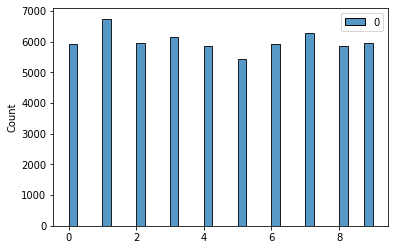

In [7]:
sns.histplot(y_train)

Target vectors consist of digits from _0_ to _9_,  

it's not convenient to use this form for training, so we'll use _one-hot encoding_.

If $y^{(i)} = 4$, then after encoding $y^{(i)} = (0, 0, 0, 1, 0, 0, 0, 0, 0, 0)$,  

and target vector $y_{m\times1}$ after ecnoding will have shape $(m, K)$, where $K$ - number of classes

In [8]:
def one_hot(y, K):
    '''
    Argumnets:
    y - target vector
    K - number of classes
    
    Returns:
    y_ext - one-hot encoded vector y
    '''
    # expand the array
    zero_pad = np.zeros((y.shape[0], K - 1))
    y_ext = np.concatenate((y, zero_pad), axis = 1)
    
    # One-hot encoding
    for i in range(y.shape[0]):
        for j in range(K):
            
            y_ext[i, j] = 1 if y[i] == j else 0
    
    return y_ext

In [9]:
K = 10 # number of classes

y_train = one_hot(y_train, K)
y_test = one_hot(y_test, K)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

Now $y_{j}^{(i)}$ represents _ith_ image with digit equals to _j_, if $y_{j}^{(i)}$ = 1. Other values of row $y^{(i)}$ equals zero.

Let's divide *x_train* into _training set_ and _cross-validation set_.

In [10]:
# Cross-validation set
x_valid = x_train[50000:]
y_valid = y_train[50000:]
# Training set
x_train = x_train[:50000]
y_train = y_train[:50000]

print('Training set shape: {} Dev set shape: {}'.format(x_train.shape, x_valid.shape))

Training set shape: (50000, 784) Dev set shape: (10000, 784)


Change shape from _(m, n)_ to _(n, m)_

In [11]:
X_train = x_train.T
Y_train = y_train.T

X_valid = x_valid.T
Y_valid = y_valid.T

X_test = x_test.T
Y_test = y_test.T

# Building the model
We'll build 3-layer perceptron and train it with _Adam algorithm_.

#### Network architecture:

- _Input layer_ is our data $x_{n\times1}^{(i)}$  
- _Hidden layer_ with *sigmoid* activation function  
- _Output layer_ with _softmax_ activation function.  

Predicted target variable may be represented as:  
$F(x) = \Psi\left(\phi\left( {x}W_1 + b_1 \right)W_2 + b_2\right)$  
Where $\Psi$ - _softmax_ function, $\phi$ - _sigmoid_   

Target variable $y$ has _multinomial distribution_ so we can use _cross entropy_ as our _loss function_.

_Loss function and gradients_:
1. $\mathcal{L} = -\frac{1}{m}\sum^{m}_{i=1} {\sum^{K}_{j=1} ({y_{j}^{(i)}\ln{\hat{y}_{j}^{(i)}})}}$, where $\hat{y}_{j}^{(i)}$ is predicted target variable
2. Each layer has its matrix of parameters $W$ and $b$ of _ith_ layer, $W^{(i)}$ and $b^{(i)}$ is a matrix of parameters of the _$ith$_ hidden layer. $(b^{(i)}, W^{(i)}) = \begin{pmatrix}
b_{1}^{(i)} & W_{11}^{(i)} & W_{12}^{(i)} & ...\\
b_{2}^{(i)} & W_{21}^{(i)} & W_{22}^{(i)} & ...\\
b_{3}^{(i)} & W_{31}^{(i)} & W_{32}^{(i)} & ...\\
.                 & .                 & .            \\
\end{pmatrix}$  
Shape of $W^{(i)}$ is $(n_{i}, n_{i-1})$, shape of $b^{(i)}$ is $(n_{i}, 1)$ where $n_i$ is number of nodes in _ith_ layer. Input layer is _0th_ layer.  

### Train loop
1. Initialize hyperparameters  


2. Train loop:
    * Divide training and cross-validation set into minibatches
    * For minibaych in minibatches:
        * Compute target values $\hat{y}^{(i)}$
        * Compute _loss_ $\mathcal{L} = -\frac{1}{m}\sum^{m}_{i=1} {\sum^{K}_{j=1} ({y_{j}^{(i)}\ln{\hat{y}_{j}^{(i)}})}} + \frac{\lambda}{m}\sum {W_{jk}^2}$, where $\lambda$ - regularization hyperparameter
        * Compute gradients $\frac{\partial\mathcal{L}}{\partial\Theta_{jk}^{(i)}}$
        * Update parameters 
            - $W_{jk}^{(i)} = W_{jk}^{(i)} - \alpha\frac{\partial\mathcal{L}}{\partial W_{jk}^{(i)}}$     
            - $b_{j}^{(i)} = b_{j}^{(i)} - \alpha\frac{\partial\mathcal{L}}{\partial b_{j}^{(i)}}$
    

In [12]:
def sigmoid(Z):
    """
    Arguments:
    Z - a scalar or numpy array of any size
    
    Return:
    sigmoid(Z)
    """
    
    return 1/(1 + np.exp(-Z))

In [13]:
def softmax(Z):
    """
    Arguments:
    Z - numpy array of any size
    
    Return:
    softmax(Z) = exp(Zi) / sum(exp(Zi))
    """
    
    A = np.exp(Z) / np.sum(np.exp(Z), axis = 0)
    
    return A

In [14]:
def random_mini_batches(X, Y, mini_batch_size = 256):
    """
    Create a list of random mini batches from (X, Y)
    
    Arguments:
    X - dataset, size = (n, m)
    Y - label vecor, size = (number of labels, m)
    
    Return:
    mini_batches - list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]
    mini_batches = list()
    
    permutation = list(np.random.permutation(m)) # create a list of permutations
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))
    
    # Partition
    num_complete_minibatches = np.floor(m/mini_batch_size).astype(int)
    for k in range(num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    # Handling the end casse (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:, mini_batch_size*(m // mini_batch_size) : ]
        mini_batch_Y = shuffled_Y[:, mini_batch_size*(m // mini_batch_size) : ]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [15]:
def initialize_parameters(dims):
    """
    Arguments:
    dims - list of the dimensions of layers, the first element is number of features,
        the last is a number of labels, type = list
    
    Return:
    parameters - Wi - weights, bi - bias term for i-th layer, type = dict
    parameters = {..., Wi : , bi : , ...}
    """
    
    L = len(dims) - 1 # The input layer doesn't count in layer number
    parameters = dict()
    
    for l in range(L):
        
        parameters['W'+str(l+1)] = np.random.randn(dims[l+1], dims[l]) * 0.01
        parameters['b'+str(l+1)] = np.zeros((dims[l+1], 1))
        
    return parameters

In [16]:
def forward_propagation(X, parameters):
    """
    Arguments:
    X - dataset
    parameters - dictionary with W - weights, b - bias term
    L - number of layers
    
    Return:
    forward_cache - dictionary with Zi and Ai values
    """
    L = len(parameters) // 2
    forward_cache = {'A0' : X, 'Z0' : X}
    
    for l in range(L - 1):
        
        forward_cache['Z'+str(l+1)] = np.dot(parameters['W'+str(l+1)], forward_cache['A'+str(l)]) + parameters['b'+str(l+1)]
        forward_cache['A'+str(l+1)] = sigmoid(forward_cache['Z'+str(l+1)])
    # Handling output layer
    forward_cache['Z'+str(L)] = np.dot(parameters['W'+str(L)], forward_cache['A'+str(L-1)]) + parameters['b'+str(L)]
    forward_cache['A'+str(L)] = softmax(forward_cache['Z'+str(L)])
    
    return forward_cache

In [17]:
def compute_cost(A, Y, parameters, lambd):
    """
    Arguments:
    A - an output layer value
    Y - true label
    parameters - weights and bias terms
    lambd - regularization hyperparameter
    
    Return:
    cost - cross-entropy cost
    """
    reg = 0
    
    for l in range(len(parameters)//2):
        reg += np.sum(parameters['W'+str(l+1)]**2)
    
    cost = -1 * np.sum(Y*np.log(A)) + lambd/2 * reg
    
    return cost

In [18]:
def backward_propagation(Y, forward_cache, parameters, lambd):
    """
    Arguments:
    forward_cache - dictionary with Zi and Ai
    parameters - weights and bias terms
    lambd - regularization hyperparameter
    
    Return:
    grads - dictionary with dWi and dbi
        dWi - derivative of the loss with the respect to Wi
        dbi - derivative of the loss with the respect to bi
    """
    
    m = Y.shape[1]
    
    L = len(parameters) // 2
    grads = {'dZ'+str(L) : forward_cache['A'+str(L)] - Y}
    dZL = grads['dZ' + str(L)]
    grads['dW'+str(L)] = 1/m * np.dot(dZL, forward_cache['A' + str(L-1)].T) + lambd/m * parameters['W'+str(L)]
    grads['db'+str(L)] = 1/m * np.sum(dZL, axis = 1, keepdims = True)
    
    for l in range(L - 1, 0, -1):
        
        grads['dZ'+str(l)] = 1/m * np.dot(parameters['W' + str(l+1)].T, grads['dZ'+str(l+1)])*forward_cache['A'+str(l)]*(1-forward_cache['A'+str(l)])
        grads['dW'+str(l)] = 1/m * np.dot(grads['dZ'+str(l)], forward_cache['A'+str(l-1)].T)+lambd/m*parameters['W'+str(l)]
        grads['db'+str(l)] = 1/m * np.sum(grads['dZ'+str(l)], axis = 1, keepdims = True)
        
    return grads

In [19]:
def initialize_adam(parameters):
    """
    Arguments:
    parameters - dictionary with W - weights, b - bias terms
    
    Return:
    v - python dictionary that will contain the exponentially weighted average of the gradient.
            v["dW" + str(l)] = ...
            v["db" + str(l)] = ...
    s - python dictionary that will contain the exponentially weighted average of the squared gradient.
            s["dW" + str(l)] = ...
            s["db" + str(l)] = ...
    """
    
    L = len(parameters) // 2
    v = dict()
    s = dict()
    
    
    for l in range(L):
        
        v["dW" + str(l+1)] = np.zeros((parameters['W' + str(l+1)].shape[0], parameters['W' + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters['b' + str(l+1)].shape[0], parameters['b' + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters['W' + str(l+1)].shape[0], parameters['W' + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters['b' + str(l+1)].shape[0], parameters['b' + str(l+1)].shape[1]))
    
    return v, s

In [20]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1 = 0.9, beta2 = 0.999, epsilon = 10**(-8)):
    """
    Arguments:
    parameters - python dictionary with your parameters:
                parameters['W' + str(l)] = Wl
                parameters['b' + str(l)] = bl
    grads - python dictionary with your gradients for each parameters:
                grads['dW' + str(l)] = dWl
                grads['db' + str(l)] = dbl
    v - Adam variable, moving average of the first gradient, python dictionary
    s - Adam variable, moving average of the squared gradient, python dictionary
    learning_rate - the learning rate, scalar.  
    epsilon - hyperparameter preventing division by zero in Adam updates

    Return:
    parameters - python dictionary containing your updated parameters 
    v - Adam variable, moving average of the first gradient, python dictionary
    s - Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2
    
    v_corrected = dict()
    s_corrected = dict()
    
    for l in range(L):
        
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads['db' + str(l+1)]
        
        v_corrected["dW" + str(l+1)] = v['dW' + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v['db' + str(l+1)] / (1 - beta1**t)
        
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * grads['dW' + str(l+1)]**2
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * grads['db' + str(l+1)]**2

        s_corrected["dW" + str(l+1)] = s['dW' + str(l+1)] / (1 - beta2**t)
        s_corrected["db" + str(l+1)] = s['db' + str(l+1)] / (1 - beta2**t)
        
        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * v_corrected['dW' + str(l+1)] / (np.sqrt(s_corrected['dW' + str(l+1)]) + epsilon) 
        parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * v_corrected['db' + str(l+1)] / (np.sqrt(s_corrected['db' + str(l+1)]) + epsilon)
        
    return parameters, v, s

In [21]:
def model(X, Y, X_val, Y_val, dims, learning_rate = 0.001, num_epochs = 15000, mini_batch_size = 128, lambd = 0, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
    """
    Arguments:
    X - training dataset
    Y - training target vector
    X_val - cross-validation dataset
    Y_val - cross-validation target vector
    dims - list of the dimensions of layers
    learning_rate -  learning rate hyperparameter, default -- 0.001
    num_epochs - number of epochs, default -- 15000
    lambd - regularization hyperparameter, default -- 0
    print_cost - bool, if True - print cost each 1000 iterations, default -- False
    
    Return:
    parameters - learned parameters, python dictionary
    """
    # Initialize all
    parameters = dict()
    forward_cache = dict()
    grads = dict()
    costs = list() # list of costs after each # of epochs for training set
    costs_val = list()# list of costs after # of epochs for cross-validation set
    accur = list() # list of errors on training set
    accur_val = list() # list of errors on cross-validation set
    m = X.shape[1]
    m_val = X_val.shape[1]
    
    parameters = initialize_parameters(dims)
    v, s = initialize_adam(parameters)
    L = len(parameters) // 2
    
    for i in range(num_epochs):
                
        
        cost_total = 0
        minibatches = random_mini_batches(X, Y, mini_batch_size)
            
        for minibatch in minibatches:
                
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation
            forward_cache = forward_propagation(minibatch_X, parameters)
            # Compute cost and add it to cost_total
            cost_total += compute_cost(forward_cache['A'+str(L)], minibatch_Y, parameters, lambd)
            # Backward propagation
            grads = backward_propagation(minibatch_Y, forward_cache, parameters, lambd)
            
            # Update parameters
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, i+1, learning_rate, epsilon)
        # Compute average cost    
        cost_avg = cost_total / m
        
        
            
        if i % 10 == 0:
            cost = cost_avg
            forward_cache_val = forward_propagation(X_val, parameters)
            costs_val.append(compute_cost(forward_cache_val['A'+str(L)], Y_val, parameters, lambd)/m_val)
            costs.append(cost)
            _, accur_train = predict(X, Y, parameters)
            _, accur_valid = predict(X_val, Y_val, parameters)
            accur.append(accur_train)
            accur_val.append(accur_valid)
            if i % 25 == 0:
                print('Train cost after {} epochs: {}'.format(i, cost))
                
        
    return parameters, costs, costs_val, accur, accur_val

In [22]:
def plot_cost(costs_train, costs_valid, accur_train, accur_valid):
    """
    Arguments:
    costs_train - list of training costs after some epochs
    costs_valid - list of cross-validation costs after some epochs
    accur_train - list of accuracies on training set
    accur_valid - list of accuracies on cross-validation set
    
    Plot learning curves
    """
    
    ## Plot learning curves:
    plt.plot(costs_train, label = 'Training set')
    plt.plot(costs_valid, label = 'Dev set')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    ##
    
    ## Plot prediction accuracy curves
    plt.plot(accur_train, label = 'Training set')
    plt.plot(accur_valid, label = 'Dev set')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    ##    

In [23]:
def predict(X, Y, parameters, comp_accur = True):
    """
    Arguments:
    X - dataset
    Y - true label vector
    parameters - weights and bias terms
    
    Return:
    Y_pred - predicted label vector
    accur - accuracy of the prediction
    """
    
    L = len(parameters) // 2 
    
    forward_cache = forward_propagation(X, parameters)
    A = forward_cache['A'+str(L)]
    
    Y_pred = np.argmax(A, axis = 0)
    Y = np.argmax(Y, axis = 0)
    if comp_accur is False:
        return Y_pred
    accur = np.mean(Y == Y_pred) * 100
    
    return Y_pred, accur

# Let's train

We will try different combinations of hyperparameters and choose the best according to the perfomance

In [24]:
dims = [X_train.shape[0], 100, Y_train.shape[0]]
parameters, costs, costs_val, accur, accur_val = model(X_train, Y_train, X_valid, Y_valid, dims = dims, num_epochs = 500, lambd = 0.01)

Train cost after 0 epochs: 1.8726953722071522
Train cost after 50 epochs: 0.2356080173708816
Train cost after 100 epochs: 0.1897836324574129
Train cost after 150 epochs: 0.16976657733069803
Train cost after 200 epochs: 0.16280622248174453
Train cost after 250 epochs: 0.15976703497784756
Train cost after 300 epochs: 0.15571180014859726
Train cost after 350 epochs: 0.15356002548975262
Train cost after 400 epochs: 0.15265367637174523
Train cost after 450 epochs: 0.15153692367517646


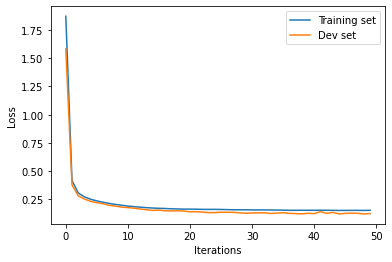

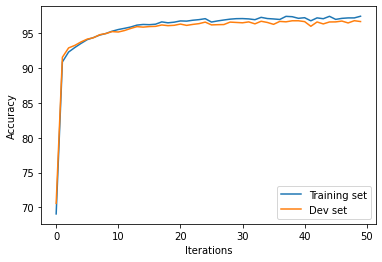

In [25]:
plot_cost(costs, costs_val, accur, accur_val)

# Prediction  

In [26]:
Y_pred_train, accur_train = predict(X_train, Y_train, parameters)
Y_pred_valid, accur_valid = predict(X_valid, Y_valid, parameters)
print('Prediction accuracy on training set: {} %'.format(accur_train))
print('Prediction accuracy on cross-validation set: {} %'.format(accur_valid))

Prediction accuracy on training set: 97.346 %
Prediction accuracy on cross-validation set: 96.67 %


In [27]:
# Return training and cross-validation target vectors to original shape
Y_train = np.argmax(Y_train, axis = 0)
Y_valid = np.argmax(Y_valid, axis = 0)
print(Y_pred_train.shape, Y_train.shape, Y_pred_valid.shape, Y_valid.shape)

(50000,) (50000,) (10000,) (10000,)


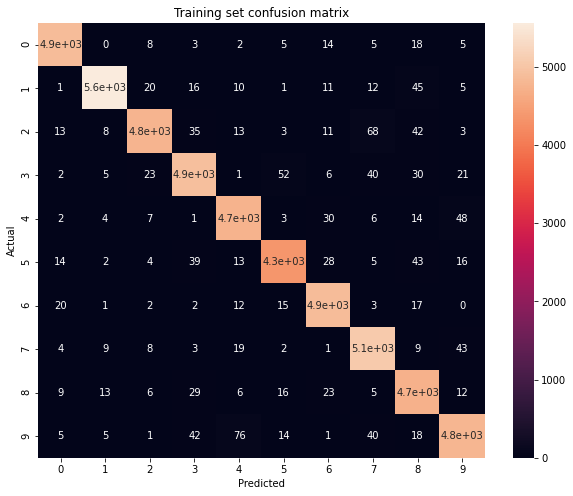

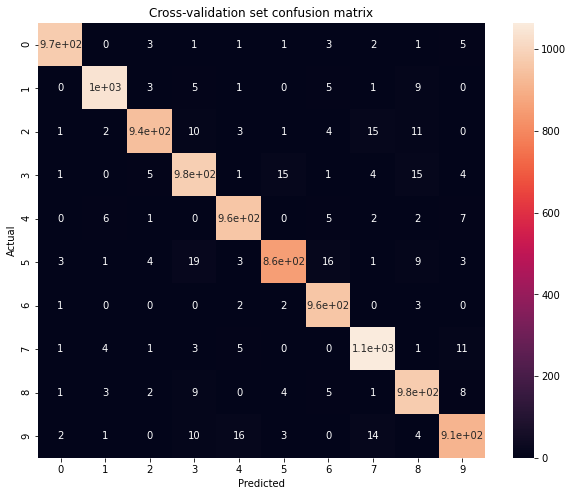

In [28]:
df_train = pd.DataFrame(data = {'Y_Actual_train':Y_train, 'Y_Pred_train':Y_pred_train})
df_valid = pd.DataFrame(data = {'Y_Actual_val':Y_valid, 'Y_Pred_valid':Y_pred_valid})
conf_matrix_train = pd.crosstab(df_train['Y_Actual_train'], df_train['Y_Pred_train'], rownames = ['Actual'], colnames = ['Predicted'])
conf_matrix_valid = pd.crosstab(df_valid['Y_Actual_val'], df_valid['Y_Pred_valid'], rownames = ['Actual'], colnames = ['Predicted'])
# Confusion matrix of training set
plt.figure(figsize = (10, 8))
sns.heatmap(data = conf_matrix_train, annot = True)
plt.title('Training set confusion matrix')
plt.show()
# Confusion matrix of training set
plt.figure(figsize = (10, 8))
sns.heatmap(data = conf_matrix_valid, annot = True)
plt.title('Cross-validation set confusion matrix')
plt.show()

### Prediction on test set

#### Accuracy

In [29]:
Y_pred_test, accur_test = predict(X_test, Y_test, parameters)
print('Prediction accuracy on the test set: {} %'.format(accur_test))

Prediction accuracy on the test set: 96.45 %


In [30]:
# Return test target vector to original shape
Y_test = np.argmax(Y_test, axis = 0)

#### Confusion matrix

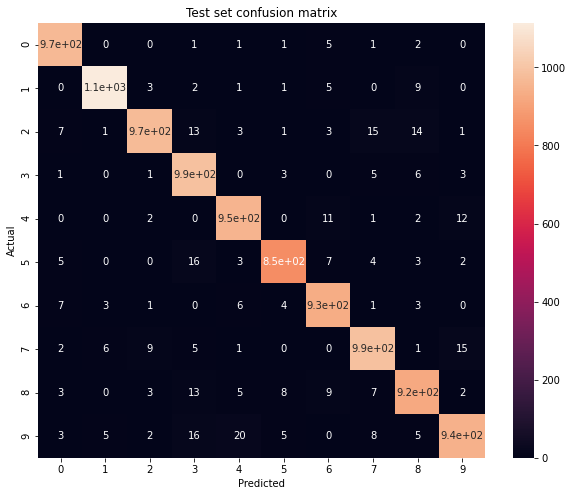

In [31]:
df_test = pd.DataFrame(data = {'Y_Actual_test' : Y_test, 'Y_Pred_test' : Y_pred_test})
conf_matrix_test = pd.crosstab(df_test['Y_Actual_test'], df_test['Y_Pred_test'], rownames = ['Actual'], colnames = ['Predicted'])

plt.figure(figsize = (10, 8))
sns.heatmap(data = conf_matrix_test, annot = True)
plt.title('Test set confusion matrix')
plt.show()

# Conclusion

Perceptron with the next architecture:  
- 1 hidden layer
- 100 nodes in the hidden layer
- sigmoid() activation function in the hidden layer
- softmax() activation function in the output layer

gives very good performance on all datasets.   
The biggest mistake achieves when the model tries to distinguish such pairs as [4, 9] and [1, 2], because these digits sometimes look the same, when they are written by hand.  
But the model is accurate and there is no huge difference between performances on datasets. Hence, this data is enough, we do not encounter _overfitting_ and _underfitting_.